In [2]:
print(__doc__)

import os
import time
import json
import pickle
import math

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.special import expit
from scipy import stats
from pylab import rcParams
import mplcursors

from sklearn.utils import check_random_state
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

from sklearn import linear_model
from sklearn import neighbors
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.utils import check_random_state
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.naive_bayes import GaussianNB

from sklearn import metrics
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score


# pd.options.display.max_rows = 20
pd.options.display.float_format = "{:.1f}".format

max_queried = 500
trainset_size = 1302

Automatically created module for IPython interactive environment


In [3]:
def data_prep():
    data = pd.read_csv("https://raw.githubusercontent.com/WenxuanHuang/ML-for-COVID-19-dataset/main/all_training.csv", sep=',')
    # Column selection
    df = data.iloc[:,np.r_[3:34]].copy()
    # define row and column index
    col = df.columns
    row = [i for i in range(df.shape[0])]
    # define imputer
    imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')
    # fit on the dataset
    imputer.fit(df)
    # transform the dataset
    df_imputed = imputer.transform(df)
    # convert back to pandas dataframe and rename back to df_normalized
    df = pd.DataFrame(data=df_imputed, index=row, columns=col)
    X = df
    y = data.target    
    # Recursive feature elimination
    rdmreg = RandomForestClassifier(n_estimators=100)
    # Define the method
    rfe = RFE(estimator=rdmreg, n_features_to_select=10)
    # Fit the model
    rfe = rfe.fit(X, y.values.ravel())
    print(rfe.support_)
    # Drop columns that failed RFE test
    col = df.columns[rfe.support_]
    X = X[col]
    X = X.to_numpy()
    print ('df:', X.shape, y.shape)
    return (X, y)


In [4]:
class BaseModel(object):

    def __init__(self):
        pass

    def fit_predict(self):
        pass


class SvmModel(BaseModel):

    model_type = 'Support Vector Machine with linear Kernel'
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training svm...')
        self.classifier = SVC(
            C=1, 
            kernel='linear', 
            probability=True,
            class_weight=c_weight
            )
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted,
                self.test_y_predicted)

class LogModel(BaseModel):

    model_type = 'Logistic Regression' 
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training logistic regression...')
        # train_samples = X_train.shape[0]
        self.classifier = LogisticRegression(
            # C=50. / train_samples,
            penalty='l1',
            solver='liblinear',
            tol=0.1,
            class_weight=c_weight
            )
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted,
                self.test_y_predicted)

class RfModel(BaseModel):

    model_type = 'Random Forest'
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training random forest...')
        self.classifier = RandomForestClassifier(
            n_estimators=500, 
            class_weight=c_weight, 
            n_jobs=-1
            )
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted, self.test_y_predicted)

In [5]:
class TrainModel:

    def __init__(self, model_object):        
        self.accuracies = []
        self.model_object = model_object()        

    def print_model_type(self):
        print (self.model_object.model_type)

    # we train normally and use the probabilities to select the most uncertain samples
    def train(self, X_train, y_train, X_val, X_test, c_weight):
        print ('Train set:', X_train.shape)
        print ('Validation set:', X_val.shape)
        print ('Test set:', X_test.shape)
        t0 = time.time()
        (X_train, X_val, X_test, self.val_y_predicted,
         self.test_y_predicted) = \
            self.model_object.fit_predict(X_train, y_train, X_val, X_test, c_weight)
        self.run_time = time.time() - t0
        return (X_train, X_val, X_test)

    # we want accuracy only for the test set
    def get_test_accuracy(self, i, y_test):
        classif_rate = np.mean(self.test_y_predicted.ravel() == y_test.ravel()) * 100
        self.accuracies.append(classif_rate)               
        print('--------------------------------')
        print('Iteration:',i)
        # print('--------------------------------')
        print('y-test set:',y_test.shape)
        # print('Training run in %.3f s' % self.run_time,'\n')
        print("Accuracy rate is %f " % (classif_rate))    
        # print("Classification report for %s:\n%s\n" % (self.model_object.classifier, metrics.classification_report(y_test, self.test_y_predicted)))
        # print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, self.test_y_predicted))
        print('--------------------------------')


In [6]:
class Normalize(object):
    
    def normalize(self, X_train, X_val, X_test):
        self.scaler = RobustScaler()
        X_train = self.scaler.fit_transform(X_train)
        X_val   = self.scaler.transform(X_val)
        X_test  = self.scaler.transform(X_test)
        return (X_train, X_val, X_test) 
    
    def inverse(self, X_train, X_val, X_test):
        X_train = self.scaler.inverse_transform(X_train)
        X_val   = self.scaler.inverse_transform(X_val)
        X_test  = self.scaler.inverse_transform(X_test)
        return (X_train, X_val, X_test) 

In [7]:
def get_random_samples(initial_samples, X_train_full, y_train_full):

    permutation = np.random.choice(len(X_train_full),initial_samples,replace=False)
    X_train = X_train_full[permutation]
    y_train = y_train_full[permutation]
    X_train = X_train.reshape((X_train.shape[0], -1))

    return (permutation, X_train, y_train)

In [8]:
def log_loss(probs):

    loss = 0
    for i in range(len(probs)):
        for prob in probs[i]:
            if prob in [0,1]:
                loss -= 0
            else:
                loss -= (prob*np.log(prob))
    ll = loss/(len(probs)*1.)

    return ll

In [9]:
class TheAlgorithm(object):

    accuracies = []

    def __init__(self, step, model_object):
        self.step = step
        self.model_object = model_object
        
    def run(self, X_train_full, y_train_full, X_test, y_test, initial_queried, max_queried):

        (permutation, X_train, y_train) = get_random_samples(initial_queried, X_train_full, y_train_full)
        self.queried = initial_queried

        X_val = np.array([])
        y_val = np.array([])
        X_val = np.copy(X_train_full)
        X_val = np.delete(X_val, permutation, axis=0)
        y_val = np.copy(y_train_full)
        y_val = np.delete(y_val, permutation, axis=0)

        normalizer = Normalize()
        X_train, X_val, X_test = normalizer.normalize(X_train, X_val, X_test)
           
        self.clf_model = TrainModel(self.model_object)
        (X_train, X_val, X_test) = self.clf_model.train(X_train, y_train, X_val, X_test, 'balanced')
        active_iteration = 1
        self.clf_model.get_test_accuracy(1, y_test)

        while self.queried <= max_queried-self.step:

            active_iteration += 1
            self.queried += self.step

            # (mc_permutation, X_subset, y_subset) = \
            #     get_random_samples(200, X_val, y_val) # 100 is the subset size
            # print('Indexes in the subset for X_val:', mc_permutation)
            # print ('Subset:', X_subset.shape, y_subset.shape, monte_carlo_permutation.shape)
            # print ('Train:', X_train.shape, y_train.shape, permutation.shape)

            cand_probs = self.clf_model.model_object.classifier.predict_proba(X_val)

            utils = []

            for i in range(len(X_val)):
                new_train_X = X_train
                row_subset = X_val[i]
                new_train_X = np.append(new_train_X, [row_subset], axis=0)
                util = 0
                for c in [0, 1]:
                    new_train_y = y_train
                    new_train_y = np.append(new_train_y, c)
                    # print('Monte_carlo training set X:', new_train_X)
                    # print('Monte_carlo training set y:', new_train_y)
                    new_classifier = LogisticRegression(
                        penalty='l1',
                        solver='liblinear',
                        tol=0.1,
                        class_weight='balanced')
                    new_classifier.fit(new_train_X, new_train_y)
                    new_probs = self.clf_model.model_object.classifier.predict_proba(X_val)
                    # print('Probabilities subset:', new_probs)
                    util += cand_probs[i][c] * log_loss(new_probs)

                utils.append(util)

            uis = np.argsort(utils)
            # print ('Monte-carlo selected indexes:', uis)
  

            X_uncertain = [X_val[i] for i in uis[:self.step]]
            y_uncertain = [y_val[i] for i in uis[:self.step]]
            uncertain_samples = uis[:self.step]
            print ('Monte-carlo selected indexes:', uncertain_samples)
            # print ('Monte-carlo selected samples:', X_uncertain)
            # print ('Monte-carlo selected outcomes:', y_uncertain)

            X_train, X_val, X_test = normalizer.inverse(X_train, X_val, X_test)   
            X_train = np.concatenate((X_train, np.array(X_uncertain)))
            y_train = np.concatenate((y_train, np.array(y_uncertain)))

            X_val = np.delete(X_val, uncertain_samples, axis=0)
            y_val = np.delete(y_val, uncertain_samples, axis=0)

            normalizer = Normalize()
            X_train, X_val, X_test = normalizer.normalize(X_train, X_val, X_test)               

            (X_train, X_val, X_test) = self.clf_model.train(X_train, y_train, X_val, X_test, 'balanced')
            self.clf_model.get_test_accuracy(active_iteration, y_test)

        return self.clf_model.accuracies

In [10]:
def pool_experiment(model,max_queried,initial_queried,step):

    (X, y) = data_prep()
    kf = KFold(n_splits=4)
    for train_index, test_index in kf.split(X):
        X_train_full, X_test = X[train_index], X[test_index]
        y_train_full, y_test = y[train_index], y[test_index]
        
    act_alg = TheAlgorithm(step, model)
    accuracies = act_alg.run(X_train_full,y_train_full,X_test,y_test,initial_queried,max_queried)

    (permutation, X_train_selected, y_train_selected) = get_random_samples(initial_queried, X_train_full, y_train_full)
    original_accuracies=[]
    classifier_original = LogisticRegression(
            penalty='l1',
            solver='liblinear',
            tol=0.1,
            class_weight='balanced')
    x_axis = []
    for i in range(initial_queried-1,max_queried,step):
        classifier_original.fit(X_train_selected[:i+1], y_train_selected[:i+1])
        y_pred_original = classifier_original.predict(X_test)
        original_accuracies.append(accuracy_score(y_test, y_pred_original)*100)
        x_axis.append(i+1)

    plt.plot(x_axis, accuracies, 'r',label='active') 
    plt.plot(x_axis, original_accuracies, 'blue',label='non-active') 
    plt.legend()
    plt.xlabel('Sample Size')
    plt.ylabel('Accuracy')
    plt.show()

[ True False False False False False  True False  True  True False False
 False  True  True False False False False False False False False False
  True  True  True False False  True False]
df: (1736, 10) (1736,)
Train set: (50, 10)
Validation set: (1252, 10)
Test set: (434, 10)
training logistic regression...
--------------------------------
Iteration: 1
y-test set: (434,)
Accuracy rate is 78.801843 
--------------------------------
Monte-carlo selected indexes: [ 278 1106 1176  271  254]
Train set: (55, 10)
Validation set: (1247, 10)
Test set: (434, 10)
training logistic regression...
--------------------------------
Iteration: 2
y-test set: (434,)
Accuracy rate is 77.649770 
--------------------------------
Monte-carlo selected indexes: [1246  829 1113  423  827]
Train set: (60, 10)
Validation set: (1242, 10)
Test set: (434, 10)
training logistic regression...
--------------------------------
Iteration: 3
y-test set: (434,)
Accuracy rate is 79.953917 
-------------------------------

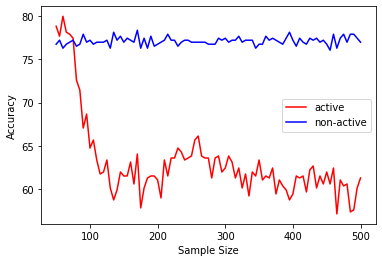

In [11]:
pool_experiment(LogModel,500,50,5)